<a href="https://colab.research.google.com/github/amrutha992/Ghibli_Image_Generator/blob/main/Ghibli_image_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from diffusers import ControlNetModel, StableDiffusionXLControlNetImg2ImgPipeline, AutoencoderKL
from diffusers import DDIMScheduler, EulerAncestralDiscreteScheduler
from diffusers.utils import load_image
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
import os

In [ ]:
controlnet = ControlNetModel.from_pretrained(
    "xinsir/anime-painter",
    torch_dtype=torch.float16
)

controlnet = controlnet.to("cuda",dtype=torch.float16)


pipe = StableDiffusionXLControlNetImg2ImgPipeline.from_pretrained(
    "John6666/studio-chatgpt-ghibli-illustrious-v10-sdxl",
    controlnet=controlnet,
    safety_checker=None,
    torch_dtype=torch.float16,
)

pipe = pipe.to("cuda",dtype=torch.float16)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/2.50G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/721 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/589 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/574k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/496 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/765 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/484 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/924 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

Keyword arguments {'safety_checker': None} are not expected by StableDiffusionXLControlNetImg2ImgPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:


def resize_image_with_aspect_ratio(image_path, max_dim=1024):
    """
    Resize an image while maintaining the aspect ratio.
    The maximum dimension (width or height) is resized to `max_dim`.

    Args:
        image_path (str): Path to the input image.
        max_dim (int): Maximum allowed dimension (default is 1024).

    Returns:
        Image: A resized PIL Image object.
    """
    img = Image.open(image_path)
    original_width, original_height = img.size

    # Determine the scaling factor
    scale = min(max_dim / original_width, max_dim / original_height)

    # Calculate new size while maintaining aspect ratio
    new_width = int(original_width * scale)
    new_height = int(original_height * scale)

    resized_img = img.resize((new_width, new_height))
    return resized_img


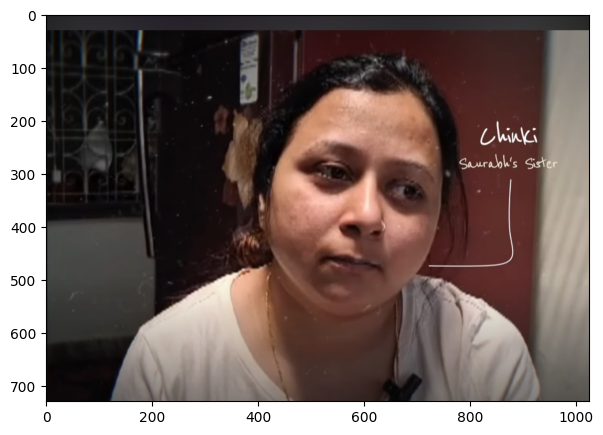

In [ ]:
image_path = "/content/Screenshot 2025-03-28 123038.png"
input_image = resize_image_with_aspect_ratio("/content/Screenshot 2025-03-28 123038.png", max_dim=1024)
input_image = input_image.convert("RGB")


plt.figure(figsize=(7,7))
plt.imshow(input_image)
plt.show()

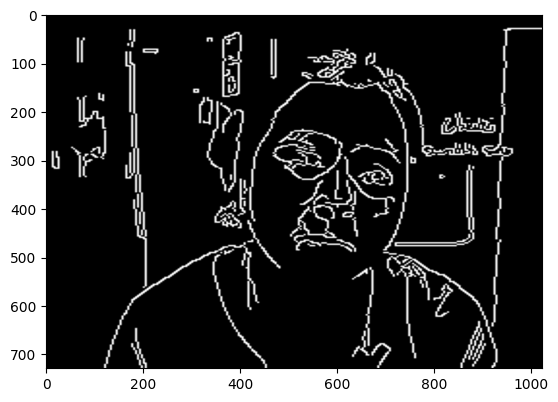

In [ ]:
def make_canny_condition(image):
    org_shape = image.size
    image = np.array(image.resize((256,256)), dtype=np.uint8)
    image = cv2.Canny(image, 100,200)
    image = image[:, :, None]
    image = np.concatenate([image, image, image], axis=2)
    image = Image.fromarray(image)
    return image.resize(org_shape)


control_image_canny = make_canny_condition(input_image)
plt.imshow(control_image_canny)
plt.show()

  0%|          | 0/18 [00:00<?, ?it/s]

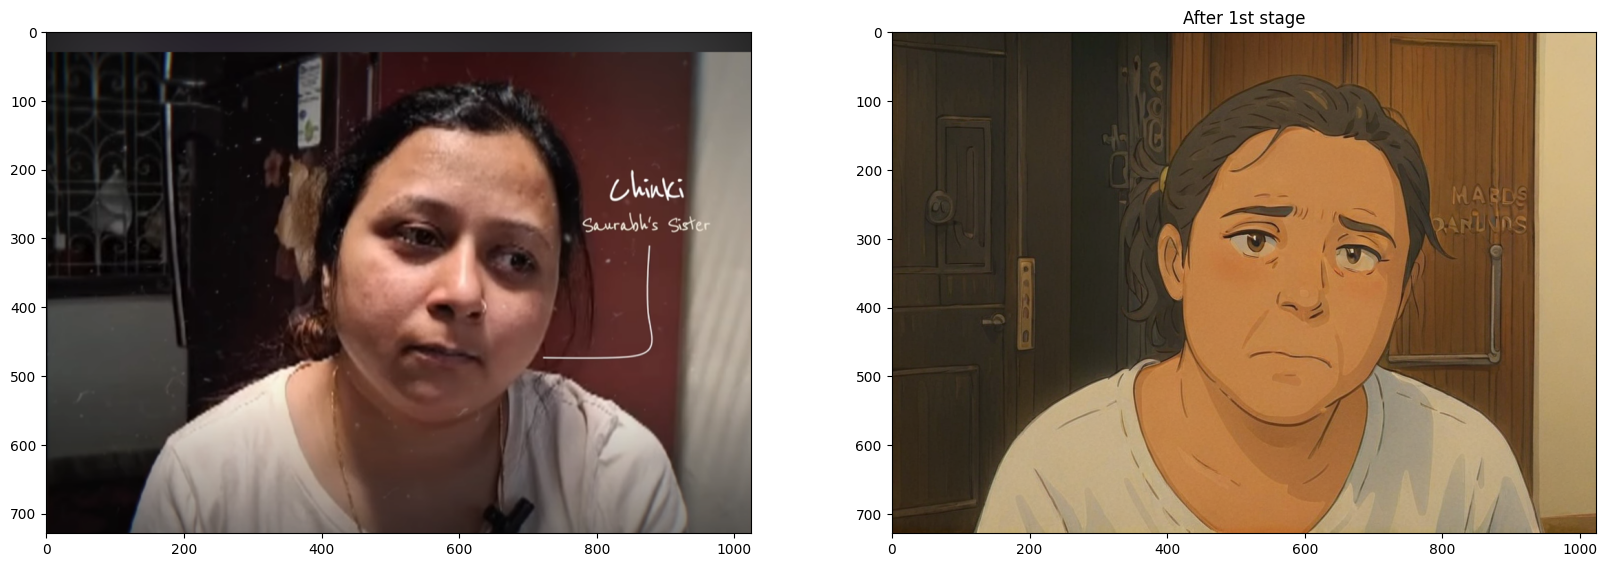

In [ ]:
# prompt = ''' men looking at the camera''' #musk.png
prompt = ''' photograph, woman, Indian, medium skin tone, dark hair, black hair, tied hair, brown eyes, white shirt, indoors, kitchen background, red wall, metal door, "Chinki Sundar" text, casual clothing, close-up, portrait, natural lighting, home setting, candid shot''' #girl_cat.png
prompt2 = prompt
negative_prompt = 'longbody, lowres, bad anatomy, good hands, missing fingers, extra digit, fewer digits, cropped, best quality, medium quality'


image_stage_1 = pipe(
    prompt=prompt,
    prompt2=prompt2,
    # negative_prompt=neg_prompt,
    num_inference_steps=30,#0-1000
    strength=0.6,#0.1-1 (Howmuch of the original image you want to keep)
    eta=1.0,
    image=input_image,
    control_image=control_image_canny,
    controlnet_conditioning_scale= 0.9,# 0.5-1.2  (Howmuch importnace to give the black and white control_image)
    guidance_scale=7,# 5-7 (Importnace for the text prompt)
    generator=torch.manual_seed(7777777),
).images[0]



plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.subplot(1, 2, 2)
plt.title("After 1st stage")
plt.imshow(image_stage_1 )
plt.show()


In [ ]:
# Save the generated image
img_name = image_path.split('/')[-1].split('.')[0]
image_stage_1.save(f'generated_{img_name}.png')  # Save the image

'musk'